# Bayesian model evaluation

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import dill
import arviz as az
import xarray as xr
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logit, expit
from sklearn.linear_model import LinearRegression
import pymc as pm
import itertools
from scipy.stats import pearsonr
import warnings
import networkx as nx
import os

In [2]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [3]:
# Supress select warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")
az.rcParams["plot.max_subplots"] = 60

In [4]:
# Set global Seaborn theme
sns.set_theme(
    style="white",  # White background
    context="notebook",  # Default context; adjust font sizes for notebooks
    rc={
        "axes.spines.top": False,  # Remove top spine
        "axes.spines.right": False,  # Remove right spine
        "axes.grid": False,  # Disable gridlines
        "xtick.bottom": True,  # Enable bottom ticks
        "ytick.left": True,  # Enable left ticks
        "xtick.major.size": 6,  # Length of major x-axis ticks
        "ytick.major.size": 6,  # Length of major y-axis ticks
        "axes.titlesize": 13,  # Font size for titles
        "axes.labelsize": 11,  # Font size for axis labels
        "legend.fontsize": 11,  # Font size for legends
    },
)

# Set Matplotlib defaults
plt.rc("font", family="sans-serif")  # Use a sans-serif font
plt.rc("axes", titlesize=13, labelsize=11)  # Font sizes for axes and titles
plt.rc("xtick", labelsize=11)  # Font size for x-tick labels
plt.rc("ytick", labelsize=11)  # Font size for y-tick labels
plt.rc("figure", figsize=(6, 5))  # Default figure size

## Plotting and helper functions

In [5]:
def plot_observed_and_predicted_distr(
    y_true: np.array,
    y_pred: np.array,
    titles: list = ["Observed data", "Predicted values"],
):
    """
    Plot two distributions side by side: observed data and predicted values.

    Args:
        - y_true: Observed data.
        - y_pred: Predicted data.
        - titles: List of subplot titles.
        - figsize: Size of the figure.
        - bins: Number of bins for the histograms.
        - alpha: Transparency level for the histograms.
    """
    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    alpha = 0.6
    bins = 50

    # Plot observed data
    sns.histplot(y_true, bins=bins, kde=False, alpha=alpha, ax=axes[0])
    axes[0].set_title(titles[0])
    axes[0].set_xlabel("Relative abundance")
    axes[0].set_ylabel("Frequency")

    # Plot predicted data
    sns.histplot(y_pred, bins=bins, kde=False, alpha=alpha, ax=axes[1])
    axes[1].set_title(titles[1])
    axes[1].set_xlabel("Relative abundance")

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [24]:
def print_evaluation_metrics_train(metrics: dict) -> None:
    """Print model performance metrics in a structured format."""
    print("MKodel performance metrics")
    print("=" * 80)

    # Overall metrics
    print("Overall metrics:")
    print(f"  - R² (standard def): {metrics['r2_std']:.3f}")
    print(f"  - R² (variance explained): {metrics['r2_var']:.3f}")
    print(f"  - Mean absolute error: {metrics['mean_abs_error']:.3f}")
    print(f"  - Median absolute error: {metrics['median_abs_error']:.3f}")
    print(f"  - Pearson correlation: {metrics['pearson_corr']:.3f}")
    print(f"  - Spearman correlation: {metrics['spearman_corr']:.3f}")
    print(
        f"  - Bias ratio (pred/obs): {metrics['bias_metrics']['overall_bias_ratio']:.3f}"
    )
    print()

    # Bottom quartile metrics
    print("Bottom quartile metrics:")
    print(f"  - R² (standard def): {metrics['r2_std_bottom']:.3f}")
    print(f"  - R² (variance explained): {metrics['r2_var_bottom']:.3f}")
    print(f"  - Mean absolute error: {metrics['mean_abs_error_bottom']:.3f}")
    print(f"  - Median absolute error: {metrics['median_abs_error_bottom']:.3f}")
    print(f"  - Pearson correlation: {metrics['pearson_corr_bottom']:.3f}")
    print(f"  - Spearman correlation: {metrics['spearman_corr_bottom']:.3f}")
    print(f"  - Bias ratio (pred/obs): {metrics['bias_metrics']['bias_bottom']:.3f}")
    print()

    # Top quartile metrics
    print("Top quartile metrics:")
    print(f"  - R² (standard def): {metrics['r2_std_top']:.3f}")
    print(f"  - R² (variance explained): {metrics['r2_var_top']:.3f}")
    print(f"  - Mean absolute error: {metrics['mean_abs_error_top']:.3f}")
    print(f"  - Median absolute error: {metrics['median_abs_error_top']:.3f}")
    print(f"  - Pearson correlation: {metrics['pearson_corr_top']:.3f}")
    print(f"  - Spearman correlation: {metrics['spearman_corr_top']:.3f}")
    print(f"  - Bias ratio (pred/obs): {metrics['bias_metrics']['bias_top']:.3f}")
    print()

In [25]:
def print_evaluation_metrics_crossval(metrics: list[dict]) -> None:
    """Print model performance metrics for cross-validation in a structured format.
    Shows mean, min, and max for each metric across all folds for test and train."""
    print("Cross-validation performance metrics")
    print("=" * 80)

    # Helper function to calculate mean, min, and max for a metric across folds
    def summarize_metric(metrics_list, phase, key):
        values = [fold[phase][key] for fold in metrics]
        return np.mean(values), np.min(values), np.max(values)

    # Sections to report metrics for
    sections = [
        (
            "Overall metrics",
            [
                ("R² (standard def.)", "r2_std"),
                ("R² (variance explained)", "r2_var"),
                ("Mean absolute error", "mean_abs_error"),
                ("Median absolute error", "median_abs_error"),
                ("Pearson correlation", "pearson_corr"),
                ("Spearman correlation", "spearman_corr"),
            ],
        ),
        (
            "Bottom quartile metrics",
            [
                ("R² (standard def.)", "r2_std_bottom"),
                ("R² (variance explained)", "r2_var_bottom"),
                ("Mean absolute error", "mean_abs_error_bottom"),
                ("Median absolute error", "median_abs_error_bottom"),
                ("Pearson correlation", "pearson_corr_bottom"),
                ("Spearman correlation", "spearman_corr_bottom"),
            ],
        ),
        (
            "Top quartile metrics",
            [
                ("R² (standard def.)", "r2_std_top"),
                ("R² (variance explained)", "r2_var_top"),
                ("Mean absolute error", "mean_abs_error_top"),
                ("Median absolute error", "median_abs_error_top"),
                ("Pearson correlation", "pearson_corr_top"),
                ("Spearman correlation", "spearman_corr_top"),
            ],
        ),
    ]

    # Print metrics for each section
    for section_name, metric_keys in sections:
        print(section_name)
        print("-" * 80)

        for display_name, key in metric_keys:
            test_mean, test_min, test_max = summarize_metric(metrics, "test", key)
            train_mean, train_min, train_max = summarize_metric(metrics, "train", key)

            print(f"  - {display_name}:")
            print(
                f"    Test:  mean: {test_mean:.3f} | min: {test_min:.3f} | max: {test_max:.3f}"
            )
            print(
                f"    Train: mean: {train_mean:.3f} | min: {train_min:.3f} | max: {train_max:.3f}"
            )

        # Add bias metrics for each section
        if "Overall" in section_name:
            test_bias = [
                fold["test"]["bias_metrics"]["overall_bias_ratio"] for fold in metrics
            ]
            train_bias = [
                fold["train"]["bias_metrics"]["overall_bias_ratio"] for fold in metrics
            ]
        elif "Bottom" in section_name:
            test_bias = [
                fold["test"]["bias_metrics"]["bias_bottom"] for fold in metrics
            ]
            train_bias = [
                fold["train"]["bias_metrics"]["bias_bottom"] for fold in metrics
            ]
        elif "Top" in section_name:
            test_bias = [fold["test"]["bias_metrics"]["bias_top"] for fold in metrics]
            train_bias = [fold["train"]["bias_metrics"]["bias_top"] for fold in metrics]

        print(f"  - Bias ratio (pred/obs):")
        print(
            f"    Test:  mean: {np.mean(test_bias):.3f} | min: {np.min(test_bias):.3f} | max: {np.max(test_bias):.3f}"
        )
        print(
            f"    Train: mean: {np.mean(train_bias):.3f} | min: {np.min(train_bias):.3f} | max: {np.max(train_bias):.3f}"
        )
        print()

    print("=" * 80)

In [8]:
def assign_legible_trace_variables(
    trace, level_1_mapping, level_2_mapping, level_3_mapping, variable_mapping
):
    """Assign legible names to dimensions of the trace for better interpretability."""
    # Update the coordinates of the regression parameters for level 1
    trace.posterior = trace.posterior.assign_coords(
        alpha_level_1_dim_0=[
            level_1_mapping[idx] for idx in trace.posterior.alpha_level_1_dim_0.values
        ],
        beta_level_1_dim_0=[
            level_1_mapping[idx] for idx in trace.posterior.beta_level_1_dim_0.values
        ],
        beta_level_1_dim_1=[
            variable_mapping[idx] for idx in trace.posterior.beta_level_1_dim_1.values
        ],
    )

    # Update the coordinates for level 2
    if "alpha_level_2_dim_0" in trace.posterior.dims:
        trace.posterior = trace.posterior.assign_coords(
            alpha_level_2_dim_0=[
                level_2_mapping[idx]
                for idx in trace.posterior.alpha_level_2_dim_0.values
            ],
            beta_level_2_dim_0=[
                level_2_mapping[idx]
                for idx in trace.posterior.beta_level_2_dim_0.values
            ],
            beta_level_2_dim_1=[
                variable_mapping[idx]
                for idx in trace.posterior.beta_level_2_dim_1.values
            ],
        )

    # Update the coordinates for level 3
    if "alpha_level_3_dim_0" in trace.posterior.dims:
        trace.posterior = trace.posterior.assign_coords(
            alpha_level_3_dim_0=[
                level_3_mapping[idx]
                for idx in trace.posterior.alpha_level_3_dim_0.values
            ],
            beta_level_3_dim_0=[
                level_3_mapping[idx]
                for idx in trace.posterior.beta_level_3_dim_0.values
            ],
            beta_level_3_dim_1=[
                variable_mapping[idx]
                for idx in trace.posterior.beta_level_3_dim_1.values
            ],
        )

    return trace

In [9]:
def plot_calibration_and_residuals(
    y_true: np.array,
    y_pred: np.array,
    y_residual: np.array,
    metrics: dict,
) -> None:
    """
    Plot calibration and residual diagnostics in a 2x2 grid using provided residuals and bias metrics.

    Args:
        - y_true: Observed values (ground truth).
        - y_pred: Predicted values.
        - y_residual: Residuals (predicted - observed).
        - bias_metrics: Dictionary containing bias values (overall, per decile, quartiles).
    """
    # Plot parameters
    params = {
        "alpha_scatter": 0.2,
        "alpha_density": 0.1,
        "alpha_bar": 0.8,
        "scatter_size": 15,
        "line_style": "--",
        "line_width": 1.25,
        "line_color": "red",
    }

    # Extract data from metrics dictionary
    bias_metrics = metrics["bias_metrics"]
    bias_values = bias_metrics["bias_per_decile"]
    overall_bias_ratio = bias_metrics["overall_bias_ratio"]
    r2_std = metrics["r2_std"]
    r2_var = metrics["r2_var"]

    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Calibration plot (predicted vs observed)
    sns.scatterplot(
        ax=axes[0, 0],
        x=y_true,
        y=y_pred,
        alpha=params["alpha_scatter"],
        s=params["scatter_size"],
    )
    axes[0, 0].plot(
        [min(y_true), max(y_true)],
        [min(y_true), max(y_true)],
        linestyle=params["line_style"],
        color=params["line_color"],
        linewidth=params["line_width"],
    )
    axes[0, 0].set_title("Calibration plot (predicted vs observed)")
    axes[0, 0].set_xlabel("Observed")
    axes[0, 0].set_ylabel("Predicted")

    # Add the R^2 score text
    vertical_offset = 0.02  # Space between each line of text
    horizontal_offset = 0.02
    axes[0, 0].text(
        horizontal_offset,  # Horizontal offset (left aligned)
        1.0 - vertical_offset,  # Top position
        f"R² (standard def.)= {r2_std:.3f}",
        fontsize=11,
        transform=axes[0, 0].transAxes,  # Use axes coordinate system
        verticalalignment="top",  # Align text to top
        horizontalalignment="left",  # Align text to left
    )
    axes[0, 0].text(
        horizontal_offset,
        1.0 - 3 * vertical_offset,  # Adjust for the second line
        f"R² (var. explained)= {r2_var:.3f}",
        fontsize=11,
        transform=axes[0, 0].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
    )

    # Residuals by observed values
    sns.scatterplot(
        ax=axes[0, 1],
        x=y_true,
        y=y_residual,
        alpha=params["alpha_scatter"],
        s=params["scatter_size"],
    )
    axes[0, 1].axhline(
        y=0,
        linestyle=params["line_style"],
        color=params["line_color"],
        linewidth=params["line_width"],
    )
    axes[0, 1].set_title("Residuals by observed values")
    axes[0, 1].set_xlabel("Observed")
    axes[0, 1].set_ylabel("Residuals")

    # Residual density plot
    sns.kdeplot(
        ax=axes[1, 0],
        data=y_residual,
        fill=True,
        alpha=params["alpha_density"],
    )
    axes[1, 0].set_title("Residual density plot")
    axes[1, 0].set_xlabel("Residuals")
    axes[1, 0].set_ylabel("Density")

    # Bias plot
    bars = axes[1, 1].bar(
        x=np.arange(10) + 1,
        height=bias_values,
        alpha=params["alpha_bar"],
    )
    axes[1, 1].axhline(
        y=overall_bias_ratio,
        color=params["line_color"],
        linestyle=params["line_style"],
        linewidth=params["line_width"],
    )
    axes[1, 1].text(
        x=0.95,
        y=0.8,
        s=f"Overall bias ratio: {round(overall_bias_ratio, 3)}",
        color="black",
        va="top",
        ha="right",
        transform=axes[1, 1].transAxes,
        fontsize=11,
    )
    for bar in bars:
        yval = bar.get_height()
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
            fontsize=11,
        )
    axes[1, 1].set_title("Total bias by observed values")
    axes[1, 1].set_xlabel("Observed value deciles")
    axes[1, 1].set_ylabel("Bias")

    # Finalize layout
    plt.tight_layout()
    plt.show()

In [10]:
def plot_calibration_by_group(y_true, y_pred, group_idx, group_mapping):
    # Determine the number of unique groups
    groups = np.unique(group_idx)
    n_groups = len(groups)

    # Calculate the dimensions of the grid of subplots
    n_cols = 3
    n_rows = int(np.ceil(n_groups / n_cols))

    # Set the figsize dynamically based on the number of groups (arbitrary width and height per subplot)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        constrained_layout=True,
        sharey=True,
    )

    axes = axes.ravel()  # Flatten the axs array for easy iteration
    for idx, group in enumerate(groups):
        # Select the data for the current group
        mask = group_idx == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]

        # Calculate the R^2 scores for the current group
        r2_std = r2_score(y_true_group, y_pred_group)
        r2_var = np.var(y_pred_group) / (
            np.var(y_pred_group) + np.var(y_true_group - y_pred_group)
        )

        # Plot the actual vs predicted values for the current group
        axes[idx].scatter(y_true_group, y_pred_group, alpha=0.2)

        # Add the perfect fit line
        min_val, max_val = min(y_true_group), max(y_true_group)
        axes[idx].plot(
            [min_val, max_val],
            [min_val, max_val],
            color="red",
            linestyle="--",
            linewidth=1.25,
        )

        # Add the R^2 score text
        axes[idx].text(
            0.05,
            0.95,
            f"R² (standard def.)= {r2_std:.3f}",
            fontsize=11,
            transform=axes[idx].transAxes,
        )
        axes[idx].text(
            0.05,
            0.9,
            f"R² (var. explained)= {r2_var:.3f}",
            fontsize=11,
            transform=axes[idx].transAxes,
        )

        # Set labels and title
        axes[idx].set_xlabel("Observed")
        axes[idx].set_ylabel("Predicted")
        axes[idx].set_title(f"{group_mapping.get(group, group)}")

        # Ensure the subplot axes do not overlap
        axes[idx].tick_params(axis="x")

    # Hide any empty subplots that aren't used (if the number of groups is not a perfect square)
    for ax in axes[n_groups:]:
        ax.set_visible(False)

    plt.show()

In [11]:
def plot_residuals_by_group(y_true, y_pred, group_idx, group_mapping):
    # Determine the number of unique groups
    groups = np.unique(group_idx)
    n_groups = len(groups)

    # Calculate the dimensions of the grid of subplots
    n_cols = 3
    n_rows = int(np.ceil(n_groups / n_cols))

    # Set the figsize dynamically based on the number of groups (arbitrary width and height per subplot)
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), constrained_layout=True
    )

    # Flatten the axs array for easy iteration
    axs = axs.ravel()

    for idx, group in enumerate(groups):
        # Select the data for the current group
        mask = group_idx == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        residuals_group = y_pred_group - y_true_group

        # Plot the actual values and residuals for the current group
        axs[idx].scatter(y_true_group, residuals_group, alpha=0.5)
        axs[idx].axhline(y=0, color="r", linestyle="--", linewidth=2)

        # Set labels and title
        axs[idx].set_xlabel("Observed")
        axs[idx].set_ylabel("Residuals")
        axs[idx].set_title(f"{group_mapping.get(group, group)}")

        # Ensure the subplot axes do not overlap
        axs[idx].tick_params(axis="x", labelrotation=45)

    # Hide any empty subplots that aren't used (if the number of groups is not a perfect square)
    for ax in axs[n_groups:]:
        ax.set_visible(False)

    plt.show()

In [12]:
def filter_trace_by_group(trace, level, group_name):
    posterior = trace.posterior
    filtered_trace = az.InferenceData()

    if level == "biome":
        filtered_alpha = posterior["alpha_biome"].sel(alpha_biome_dim_0=group_name)
        filtered_beta = posterior["beta_biome"].sel(beta_biome_dim_0=group_name)
        dataset = xr.Dataset(
            {"alpha_biome": filtered_alpha, "beta_biome": filtered_beta}
        )

    elif level == "realm":
        filtered_alpha = posterior["alpha_realm"].sel(alpha_realm_dim_0=group_name)
        filtered_beta = posterior["beta_realm"].sel(beta_realm_dim_0=group_name)
        dataset = xr.Dataset(
            {"alpha_realm": filtered_alpha, "beta_realm": filtered_beta}
        )

    filtered_trace = az.InferenceData(posterior=dataset)

    return filtered_trace

In [13]:
def inverse_transform_trace_data(trace):
    posterior = trace.posterior

    # Directly transforming alphas
    for alpha in ["mu_a", "alpha_biome", "alpha_realm"]:
        transformed_data = expit(posterior[alpha].values)
        trace.posterior[alpha] = xr.DataArray(
            transformed_data,
            dims=posterior[alpha].dims,
            coords=posterior[alpha].coords,
        )

    # Handling interactions between alphas and betas
    for alpha, beta in [
        ("mu_a", "mu_b"),
        ("alpha_biome", "beta_biome"),
        ("alpha_realm", "beta_realm"),
    ]:
        alpha_vals = posterior[alpha].values
        beta_vals = posterior[beta].values

        # Determine the shape differences and expand dimensions accordingly
        shape_diff = len(beta_vals.shape) - len(alpha_vals.shape)
        for _ in range(shape_diff):
            alpha_vals = np.expand_dims(alpha_vals, axis=-1)  # Expand the last axis

        # Repeat alpha_vals to match the full shape of beta_vals if necessary
        repeats = [
            beta_vals.shape[dim] if dim >= len(alpha_vals.shape) else 1
            for dim in range(len(beta_vals.shape))
        ]
        alpha_vals = np.tile(alpha_vals, repeats)

        # Compute transformed data
        transformed_data = expit(alpha_vals + beta_vals) - expit(alpha_vals)
        trace.posterior[beta] = xr.DataArray(
            transformed_data,
            dims=posterior[beta].dims,
            coords=posterior[beta].coords,
        )

    return trace

In [14]:
def forest_plot(trace, var_names):
    axes = az.plot_forest(
        data=trace,
        var_names=var_names,
        combined=True,
        hdi_prob=0.95,
    )

    ax = axes[0]
    labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = []
    for label in labels:
        new_label = (
            label.replace("[", "")
            .replace("]", "")
            .replace(",", ":")
            .replace("beta", "")
        )
        new_labels.append(new_label)

    for label in ax.get_yticklabels():
        label.set_fontsize(10)
    for label in ax.get_xticklabels():
        label.set_fontsize(10)

    # Set the new labels to the y-axis
    ax.set_yticklabels(new_labels)

    plt.tight_layout()
    plt.show()

In [15]:
def calculate_bayesian_r2(y_true, y_pred):

    r2_values = []
    for s in range(y_pred.shape[0]):
        pred = y_pred[s]
        r2 = np.var(pred) / (np.var(pred) + np.var(y_true - pred))
        r2_values.append(r2)

    return r2_values

In [16]:
def plot_performance_distribution(values, metric):
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=30, alpha=0.6, color="g", edgecolor="black")
    mean_val = np.mean(values)
    perc_2_5 = np.percentile(values, q=2.5)
    perc_97_5 = np.percentile(values, q=97.5)
    plt.axvline(
        mean_val,
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean_val:.3f}",
    )
    plt.axvline(
        perc_2_5,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"CI 2.5%: {perc_2_5:.3f}",
    )
    plt.axvline(
        perc_97_5,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"CI 97.5%: {perc_97_5:.3f}",
    )
    plt.title(f"Distribution of {metric}")
    plt.xlabel(f"{metric}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

## Load and format training data

In [18]:
# Relevant run output:

# 1. Tot abundance, sqrt; 3-level slope; Gaussian; standard features; 5k tune, 1k draw (1h 5min)
# run_folder_2025-01-09_16.06.53
# 2. Tot abundance; 3-level slope; Beta; standard features; 5k tune, 1k draw (1h 13min)
# run_folder_2025-01-09_21.07.54
# 3. Tot abundance, no trans; 3-level slope; Gaussian; standard features; 5k tune, 1k draw (1h 4min)
# run_folder_2025-01-09_23.31.40
#

In [19]:
# Load the model output dictionary and get data
training_output_path = (
    "../../data/runs/run_folder_2025-01-09_23.31.40/training_output.pkl"
)

with open(training_output_path, "rb") as in_stream:
    training_output = dill.load(in_stream)

train_data = training_output["data"]
df_pred_train = training_output["state_predictions"]
state_metrics_train = training_output["state_metrics"]
df_pred_change_train = training_output["change_predictions"]
change_metrics_train = training_output["change_metrics"]
train_model = training_output["model"]
train_trace = training_output["trace"]
train_prior_predictive = training_output["prior_predictive"]

In [20]:
# Extract variables for analysis and plotting

# Calibration and residuals, state predictions
y_true_train = df_pred_train.get_column("Observed").to_numpy()
y_pred_train = df_pred_train.get_column("Predicted").to_numpy()
y_res_train = df_pred_train.get_column("Residuals").to_numpy()

# Approximate change predictions
y_true_change_train = df_pred_change_train.get_column("Delta_observed").to_numpy()
y_pred_change_train = df_pred_change_train.get_column("Delta_predicted").to_numpy()
y_res_change_train = df_pred_change_train.get_column("Delta_residuals").to_numpy()

In [21]:
# Create mapping dictionaries for grouping variables
level_1_mapping = {
    code: name for code, name in enumerate(train_data["coords"]["level_1_values"])
}
level_2_mapping = {
    code: name for code, name in enumerate(train_data["coords"]["level_2_values"])
}
level_3_mapping = {
    code: name for code, name in enumerate(train_data["coords"]["level_3_values"])
}
variable_mapping = {
    code: var for code, var in enumerate(train_data["coords"]["x_vars"])
}

# Format and transform data in trace
train_trace = assign_legible_trace_variables(
    train_trace, level_1_mapping, level_2_mapping, level_3_mapping, variable_mapping
)
# trace = inverse_transform_trace_data(trace)

## Model evaluation on in-sample (training) data

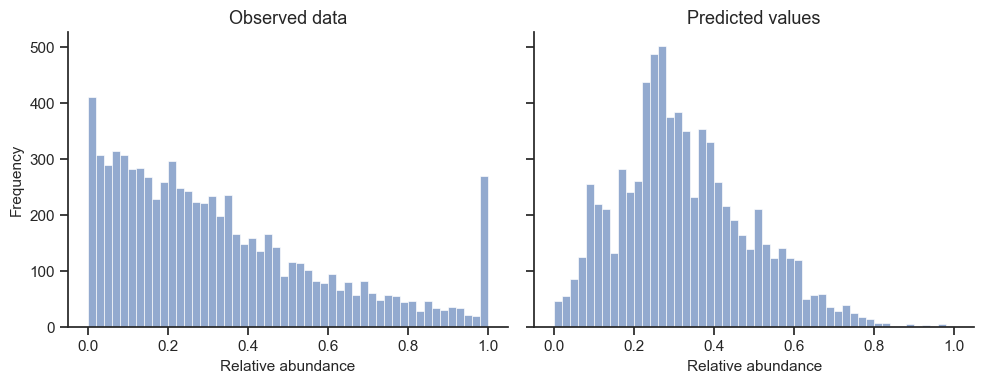

In [22]:
plot_observed_and_predicted_distr(y_true=y_true_train, y_pred=y_pred_train)

In [26]:
# Summary of model performance
# Overall and for bottom / top quartiles of observed values
print_evaluation_metrics_train(state_metrics_train)

MKodel performance metrics
Overall metrics:
  - R² (standard def): 0.461
  - R² (variance explained): 0.422
  - Mean absolute error: 0.143
  - Median absolute error: 0.109
  - Pearson correlation: 0.681
  - Spearman correlation: 0.693
  - Bias ratio (pred/obs): 1.000

Bottom quartile metrics:
  - R² (standard def): -19.817
  - R² (variance explained): 0.512
  - Mean absolute error: 0.131
  - Median absolute error: 0.118
  - Pearson correlation: 0.240
  - Spearman correlation: 0.247
  - Bias ratio (pred/obs): 3.336

Top quartile metrics:
  - R² (standard def): -1.875
  - R² (variance explained): 0.389
  - Mean absolute error: 0.239
  - Median absolute error: 0.210
  - Pearson correlation: 0.309
  - Spearman correlation: 0.302
  - Bias ratio (pred/obs): 0.685



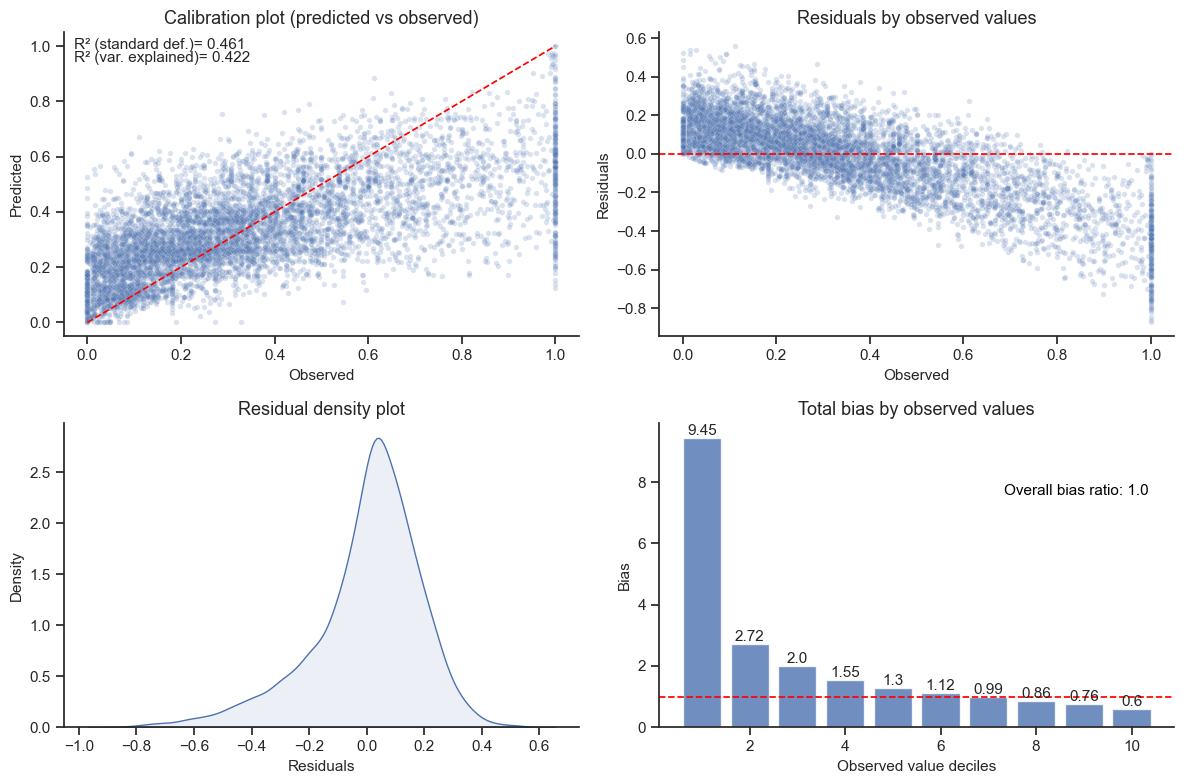

In [27]:
# Model calibration, residuals and bias analysis
plot_calibration_and_residuals(
    y_true=y_true_train,
    y_pred=y_pred_train,
    y_residual=y_res_train,
    metrics=state_metrics_train,
)

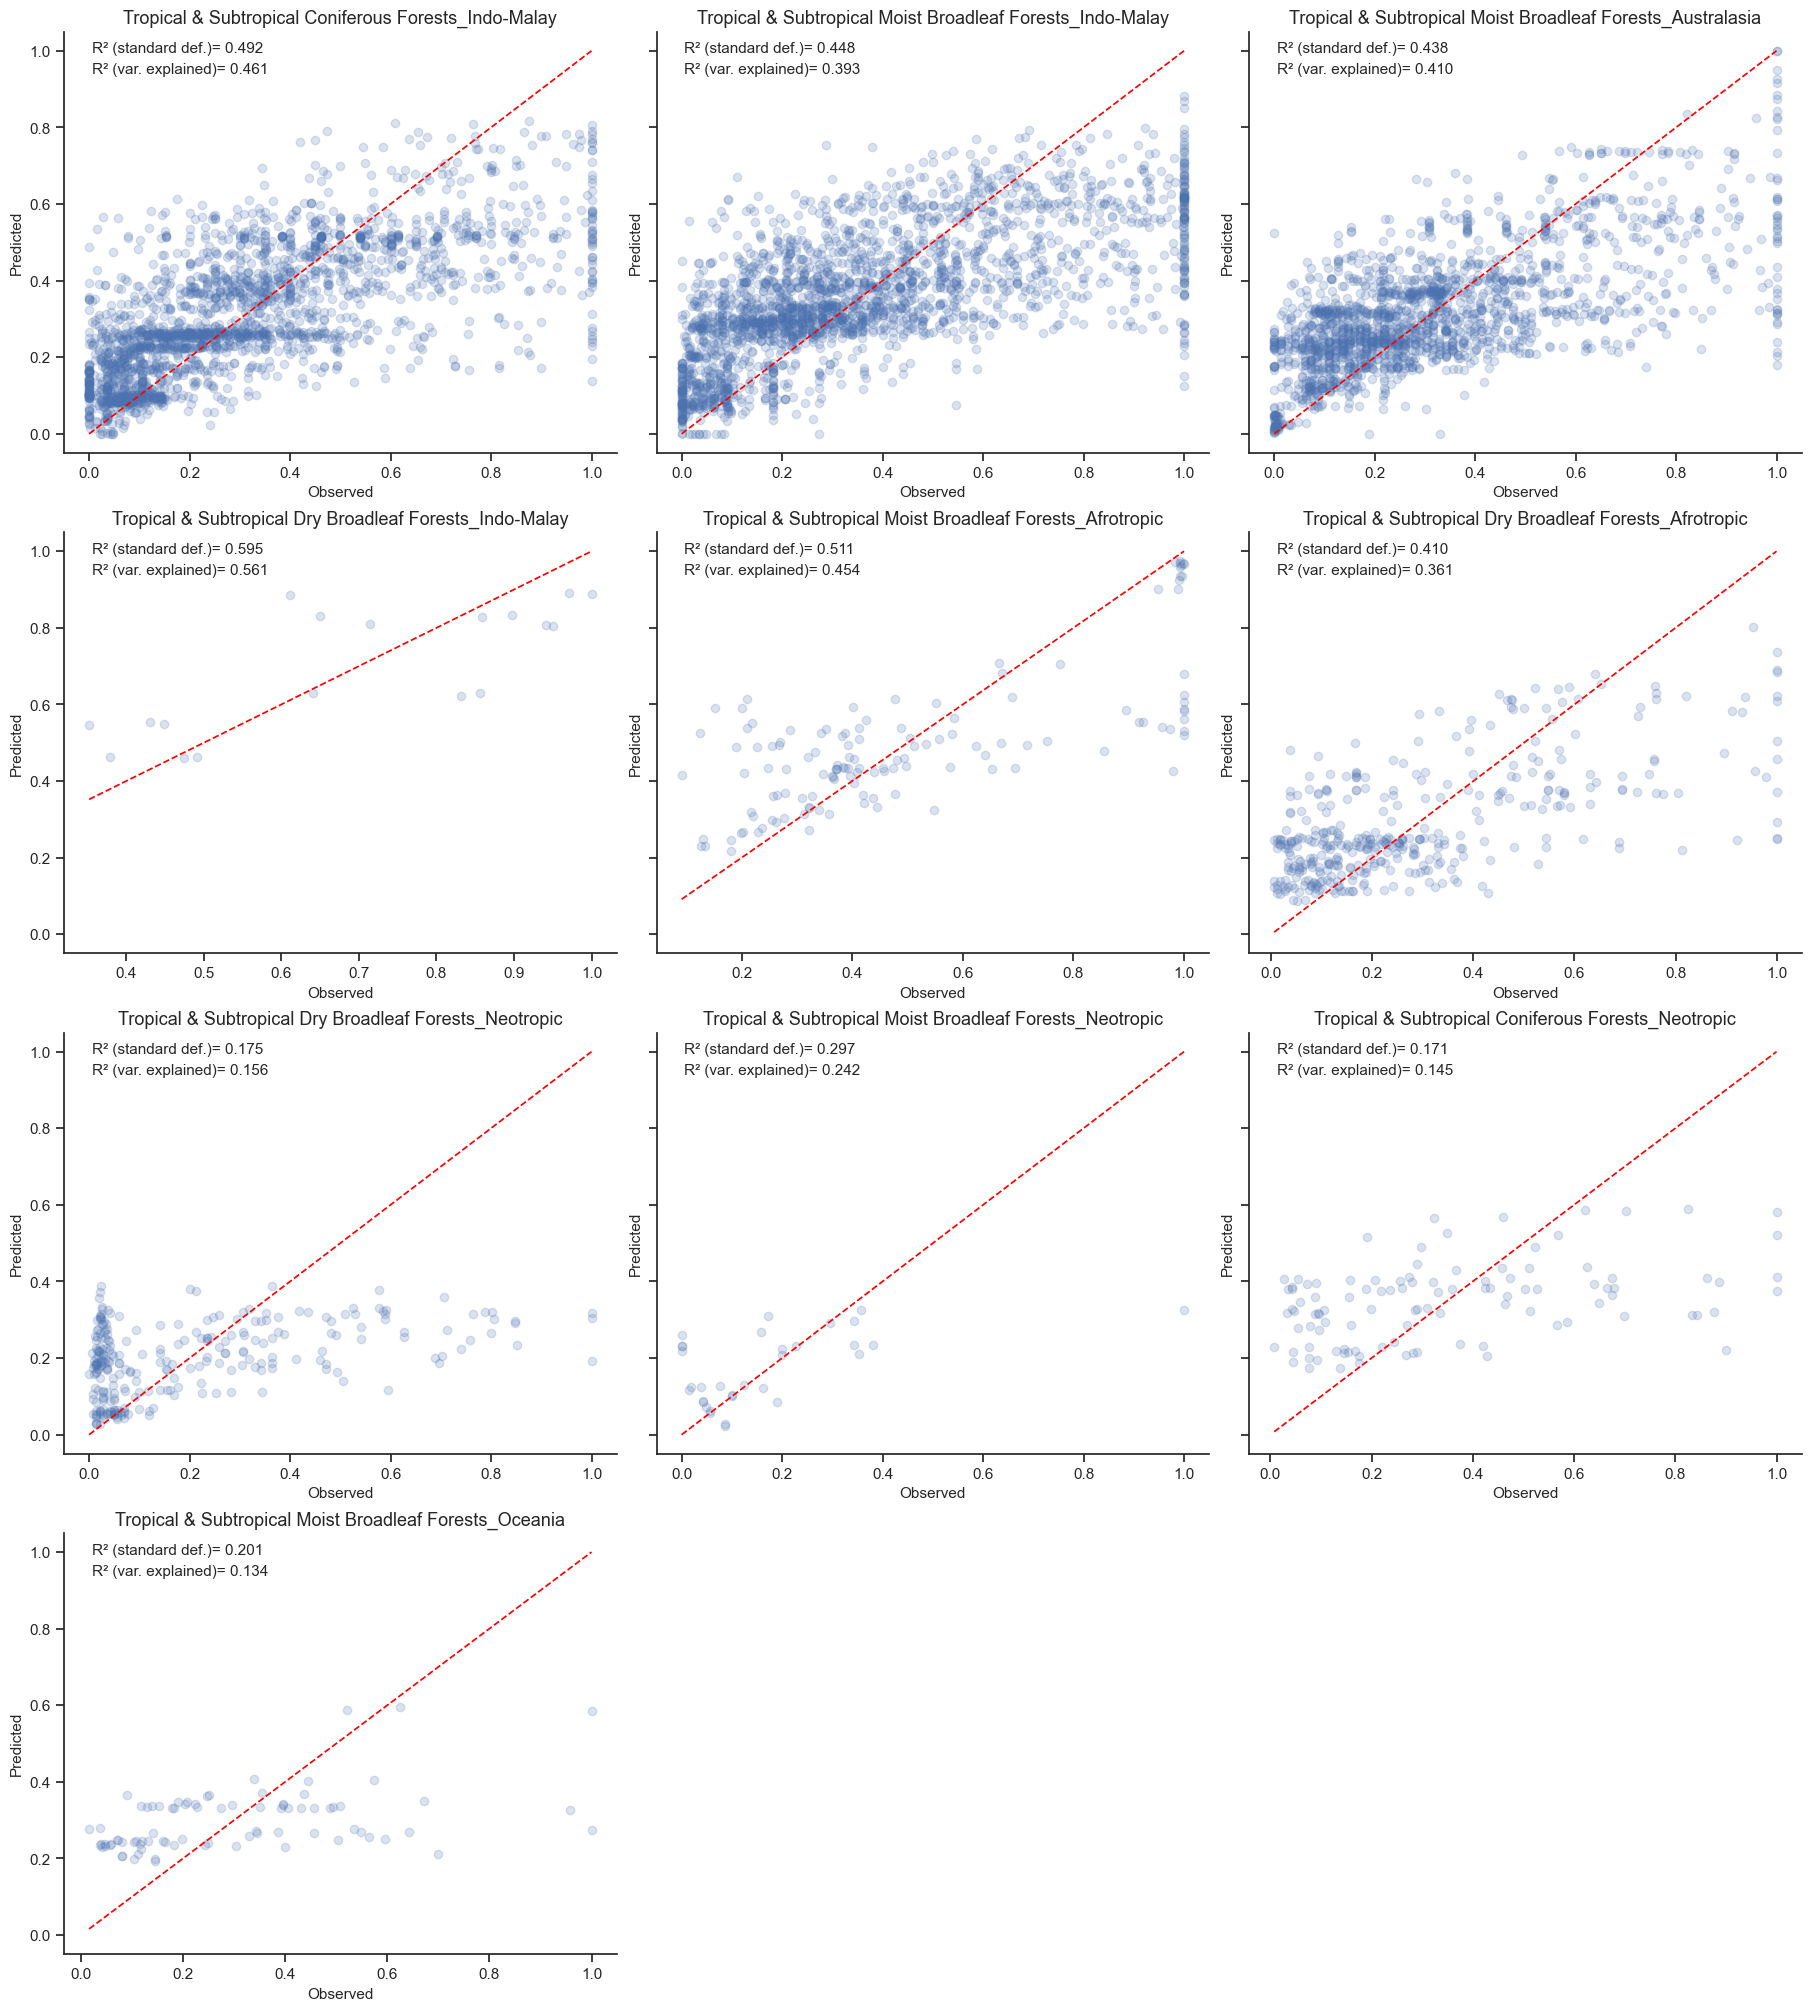

In [28]:
# Calibration plots by group
# Groups represent levels in the model hierarchy (from 1 up to 3)
plot_calibration_by_group(
    y_true=y_true_train,
    y_pred=y_pred_train,
    group_idx=train_data["level_2_idx"],
    group_mapping=level_2_mapping,
)

## Approximation of change prediction performance (in-sample)

In [30]:
print_evaluation_metrics_train(change_metrics_train)

MKodel performance metrics
Overall metrics:
  - R² (standard def): 0.316
  - R² (variance explained): 0.254
  - Mean absolute error: 0.136
  - Median absolute error: 0.094
  - Pearson correlation: 0.569
  - Spearman correlation: 0.516
  - Bias ratio (pred/obs): 0.363

Bottom quartile metrics:
  - R² (standard def): -1.301
  - R² (variance explained): 0.366
  - Mean absolute error: 0.205
  - Median absolute error: 0.172
  - Pearson correlation: 0.394
  - Spearman correlation: 0.320
  - Bias ratio (pred/obs): 0.276

Top quartile metrics:
  - R² (standard def): -1.079
  - R² (variance explained): 0.313
  - Mean absolute error: 0.212
  - Median absolute error: 0.173
  - Pearson correlation: 0.395
  - Spearman correlation: 0.308
  - Bias ratio (pred/obs): 0.273



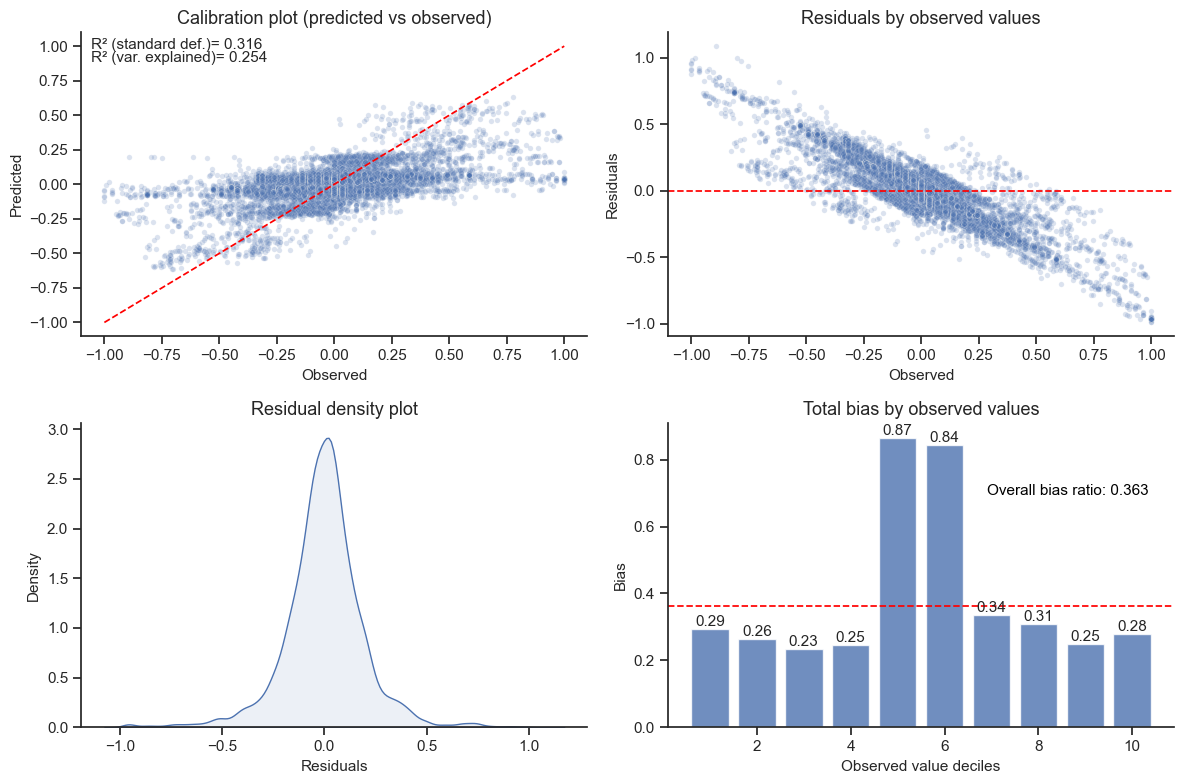

In [31]:
# Model calibration, residuals and bias analysis
plot_calibration_and_residuals(
    y_true=y_true_change_train,
    y_pred=y_pred_change_train,
    y_residual=y_res_change_train,
    metrics=change_metrics_train,
)

## Model performance on out-of-sample (test) data

In [32]:
# Relevant cross-validation output:

# Random CV
#

# Spatial CV

# Environmental CV

In [33]:
# Load the cross-validation output dictionary and get data
cv_output_path = "../../data/runs/run_folder_2025-01-10_00.44.55/cv_output.pkl"

with open(cv_output_path, "rb") as in_stream:
    cv_output = dill.load(in_stream)

cv_data = cv_output["data"]
df_pred_cv = cv_output["state_predictions"]
state_metrics_cv = cv_output["state_metrics"]
df_pred_change_cv = cv_output["change_predictions"]
change_metrics_cv = cv_output["change_metrics"]
cv_model = cv_output["models"]
cv_traces = cv_output["traces"]

# Based on concatenated test folds
df_pred_test_all = cv_output["all_test_results"]["state_predictions"]
state_metrics_test_all = cv_output["all_test_results"]["state_metrics"]
df_pred_change_test_all = cv_output["all_test_results"]["change_predictions"]
change_metrics_test_all = cv_output["all_test_results"]["change_metrics"]

In [34]:
# Extract variables for analysis and plotting

# Calibration and residuals, state predictions
y_true_test = df_pred_test_all.get_column("Observed").to_numpy()
y_pred_test = df_pred_test_all.get_column("Predicted").to_numpy()
y_res_test = df_pred_test_all.get_column("Residuals").to_numpy()

# Approximate change predictions
y_true_change_test = df_pred_change_test_all.get_column("Delta_observed").to_numpy()
y_pred_change_test = df_pred_change_test_all.get_column("Delta_predicted").to_numpy()
y_res_change_test = df_pred_change_test_all.get_column("Delta_residuals").to_numpy()

# Group indices
test_coords = [coords["test"] for coords in cv_data]
level_1_idx_test = np.concatenate([coords["level_1_idx"] for coords in test_coords])
level_2_idx_test = np.concatenate([coords["level_2_idx"] for coords in test_coords])
level_3_idx_test = np.concatenate([coords["level_3_idx"] for coords in test_coords])

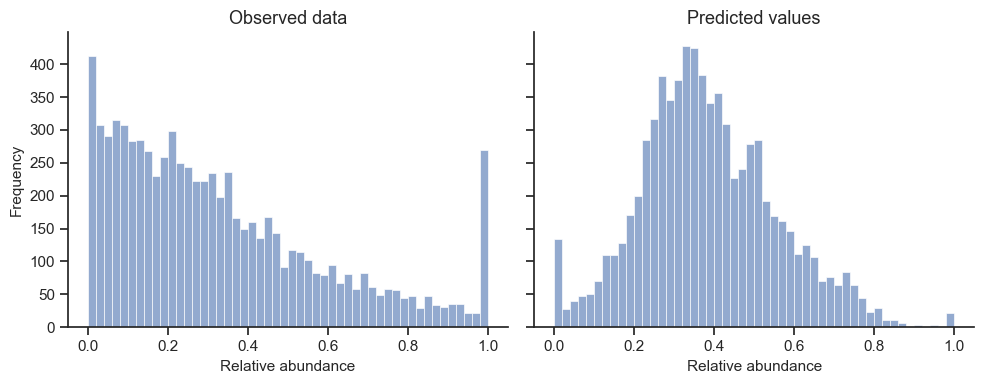

In [35]:
plot_observed_and_predicted_distr(y_true=y_true_test, y_pred=y_pred_test)

In [36]:
print_evaluation_metrics_crossval(metrics=state_metrics_cv)

Cross-validation performance metrics
Overall metrics
--------------------------------------------------------------------------------
  - R² (standard def.):
    Test:  mean: -0.332 | min: -0.483 | max: -0.191
    Train: mean: 0.461 | min: 0.459 | max: 0.463
  - R² (variance explained):
    Test:  mean: 0.247 | min: 0.242 | max: 0.256
    Train: mean: 0.417 | min: 0.415 | max: 0.419
  - Mean absolute error:
    Test:  mean: 0.243 | min: 0.226 | max: 0.267
    Train: mean: 0.143 | min: 0.142 | max: 0.145
  - Median absolute error:
    Test:  mean: 0.211 | min: 0.182 | max: 0.240
    Train: mean: 0.110 | min: 0.109 | max: 0.111
  - Pearson correlation:
    Test:  mean: 0.112 | min: 0.043 | max: 0.176
    Train: mean: 0.682 | min: 0.680 | max: 0.684
  - Spearman correlation:
    Test:  mean: 0.120 | min: 0.069 | max: 0.184
    Train: mean: 0.692 | min: 0.689 | max: 0.694
  - Bias ratio (pred/obs):
    Test:  mean: 1.180 | min: 1.074 | max: 1.256
    Train: mean: 1.000 | min: 1.000 | max: 

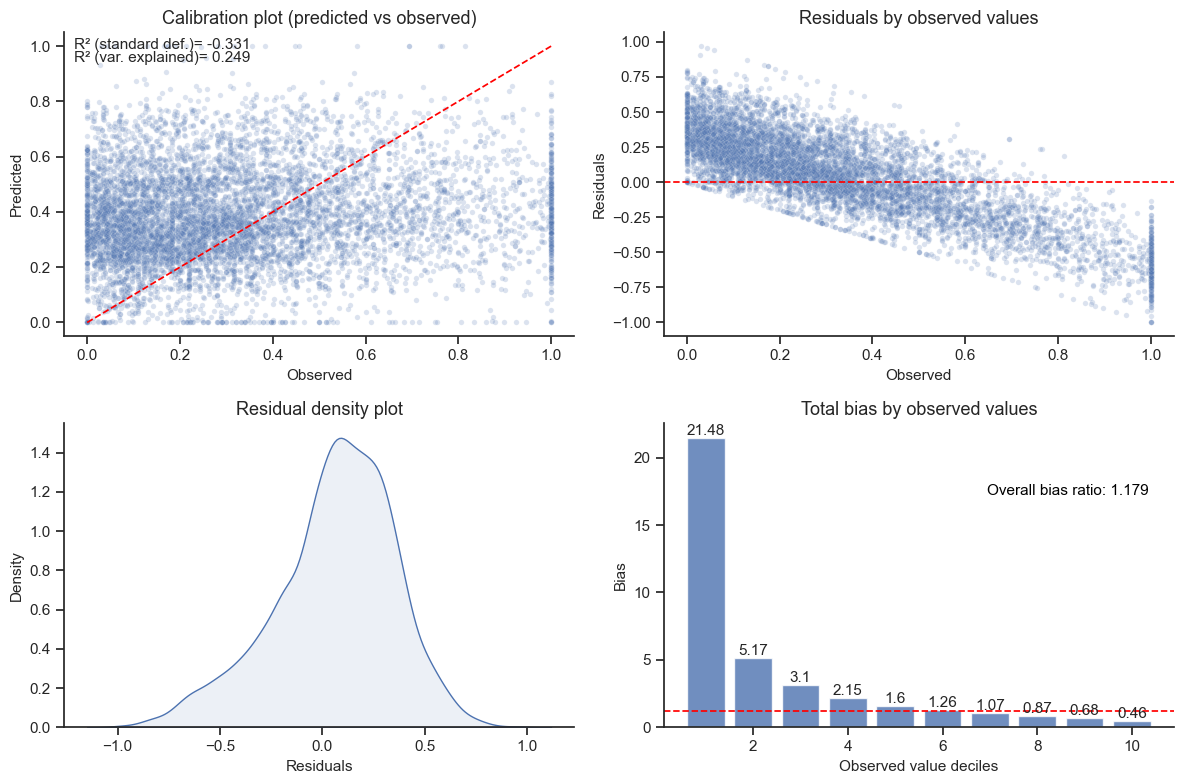

In [37]:
# Model calibration, residuals and bias analysis
plot_calibration_and_residuals(
    y_true=y_true_test,
    y_pred=y_pred_test,
    y_residual=y_res_test,
    metrics=state_metrics_test_all,
)

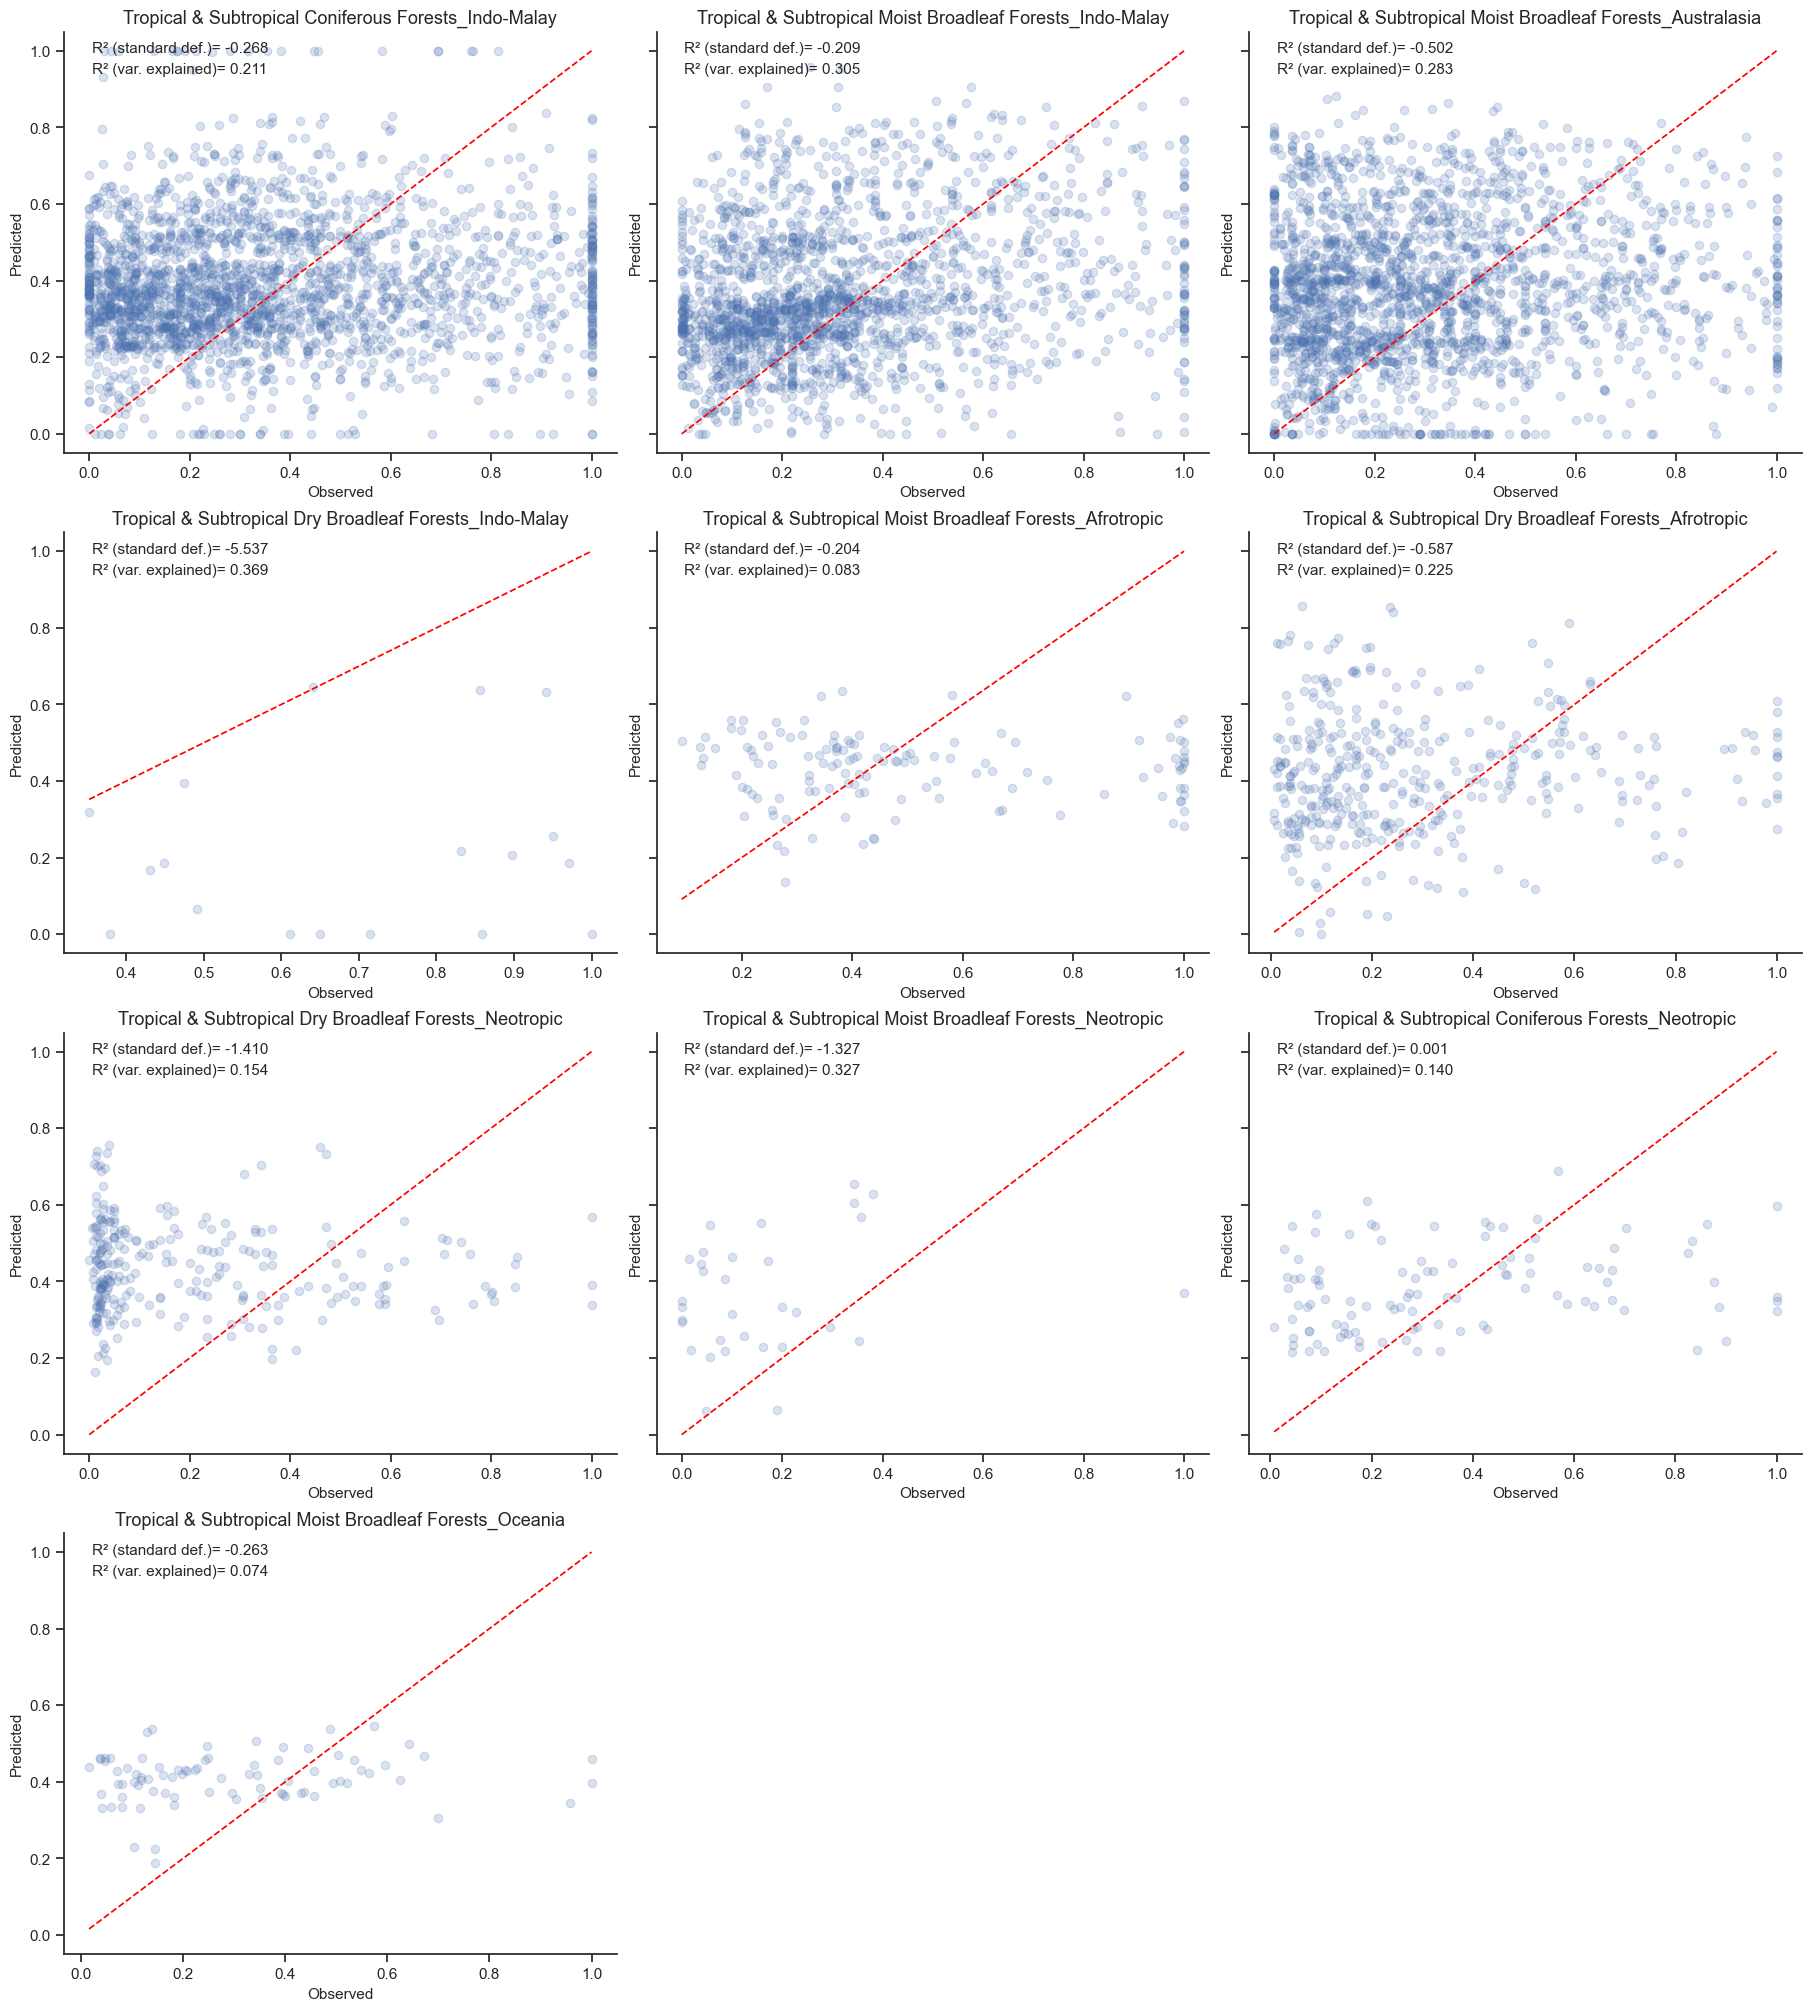

In [38]:
# Calibration plots by group
# Groups represent levels in the model hierarchy (from 1 up to 3)
plot_calibration_by_group(
    y_true=y_true_test,
    y_pred=y_pred_test,
    group_idx=level_2_idx_test,
    group_mapping=level_2_mapping,
)